# 神经风格迁移
- 神经风格迁移(Neural style Transfer)是一种基于深度学习的艺术风格转换技术。它的基本思想是利用神经网络将图像 A 的风格与图像 B 的内容进行混合，生成一幅具有 A 风格特征和 B 内容特征的新图像。
- 神经风格迁移一般通过预训练的卷积神经网络实现。
    - 通过将输入图像和风格图像分别输入到这个网络中，提取到它们在神经网络中的特征表示，然后在不同网络层上使用不同权重进行组合，通过优化损失函数，生成一张新图像，使得它同时包含了内容图像的内容特征和风格图像的风格特征。
    - 因此，在神经风格迁移中，需要一张内容图像和一张风格图像，将这两个图像组合在一起，使得组合图像同时保留内容图像的内容和风格图像的风格:
    - 为了执行神经风格迁移，我们将损失拆分为：
    1. 内容损失(content loss)，衡量 生成图像与内容图像 间的特征差异。在具体计算时，我们通常并不直接使用原始图像计算内容损失，而是使用图像的特征层激活进行计算，例如、第 2 个网络层的内容损失是内容图像和生成图像通过第 2 个网络层后激活之间的平方差。利用特征层而非原始图像计算内容损失，是由于特征层可以捕获原始图像的某些属性(例如，高层捕获前景轮廓，低层捕获物体细节)。
    2. 风格损失(style loss)，衡量 生成图像与风格图像 在风格方面相似度的一种评估指标。风格损失通常通过计算生成图片与风格图像在神经网络层的Gram 矩阵之间的距离来计算。 Gram 矩阵是特征矩阵的内积，可以捕捉到图像特征之间的相关性，反映了图像的风格信息:
    3. 风格迁移模型总损失是 内容损失和风格损失的加权平均值。

## 模型的运行流程进行分析，可以使用以下策略实现神经风格迁移:
1. 将 内容图像 传递给预训练模型；
2. 提取内容图像通过预定义层的 激活值；
3. 将 生成图像 输入模型，并在相同的预定义层提取 激活值；
4. 计算 内容图像和生成图像 在每一网络层对应的内容损失；
5. 将 风格图像通过模型的多个指定网络层，计算风格图像的 Gram 矩阵值；
6. 将 生成图像穿过风格图像通过的相同网络层，并计算对应的 Gram 矩阵值；
7. 计算两幅图像的 Gram 矩阵值的平方差作为风格损失；
8. 总损失是风格损失和内容损失的加权平均值；
9. 最终的 生成图像是能够最小化总损失的输入图像；

In [1]:
from torchvision import transforms as T
from torch.nn import functional as F
import torch
from PIL import Image
from torch import nn
import numpy as np
from torch import optim
from matplotlib import pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from torchvision.models import vgg19

/home/lenovo/anaconda3/envs/Explan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. 定义用于图像预处理和后处理的函数
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x.mul_(255))
])
postprocess = T.Compose([
    T.Lambda(lambda x: x.mul_(1./255)),
    T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
])

In [3]:
# 2. 定义GramMatrix类，【矩阵与其自身的转置矩阵相乘得到】，
'''
选用Gram矩阵的原因: 
S 风格图像; C 内容图像; P 生成图像
在NST中, P 和 S 的局部特征一样 ,尽管内容可能不同, 但是将风格图像中类似的颜色、形状和纹理应用于生成图像是 NST的重点
假设 使用 VGG19 的中间层提取 C 的图像特征 , 与提取到的 P 的图像特征 不同, 但在每层的特征集中, 对应的向量将以相似的方式相对变化:
    例如 在两个特征集中, 第一个通道的均值和第二个通道的均值之比是相似的, 这就是选用Gram矩阵进行损失计算的原因
'''
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        feat = input.view(b, c, h*w)
        G = feat@feat.transpose(1,2) # 矩阵 和 其转置矩阵的 内积，用于获取 所有向量间的关系
        G.div_(h*w)
        return G
    
# 3. 计算Gram矩阵对应的MSE损失 GramMSEloss
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = F.mse_loss(GramMatrix()(input), target)
        return(out)

In [4]:
# 4 定义模型类 VGG19
class vgg19_modified(nn.Module):
    def __init__(self): # 初始化
        super().__init__()

        features = list(vgg19(pretrained = True).features) # 提取特征
        self.features = nn.ModuleList(features).eval() 

    def forward(self, x, layers=[]): 
        order = np.argsort(layers)  # 接受 预定义网络层列表 
        _results, results = [], [] # 并返回每个网络层对应的特征 
        for ix,model in enumerate(self.features):
            x = model(x)
            if ix in layers: 
                _results.append(x)
        for o in order: 
            results.append(_results[o])
        return results if layers is not [] else x

# 定义模型对象
vgg = vgg19_modified().to(device) 

# 导入 内容和风格图像
# 根据计算性能调整图像尺寸
imgs = [Image.open(path).resize((1200,675)).convert('RGB') for path in ['style.png', 'content.png']]
style_image, content_image = [preprocess(img).to(device)[None] for img in imgs]

# 保存指定要修改的内容图像的梯度，
opt_img = content_image.data.clone()
opt_img.requires_grad = True

# 定义内容和风格 损失的层，即使用哪些中间 VGG 层，来比较 风格的Gram矩阵 和 内容的原始特征向量 
style_layers = [0, 5, 10, 19, 28] 
content_layers = [21]
loss_layers = style_layers + content_layers

# 定义 内容和风格 损失函数
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

# 定义用于 平衡 风格和内容损失的权重
style_weights = [1000/n**2 for n in [64,128,256,512,512]] 
content_weights = [1]
weights = style_weights + content_weights

# 对图像操作，
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)] # 我们通过计算从几个选定的 VGG 层获得的特征的来计算 style_image 的 style_targets 值 ，使二者风格尽可能相似
content_targets = [A.detach() for A in vgg(content_image, content_layers)] # 由于应该保留整体内容，我们使用 content_layer 变量来计算 VGG 的原始特征:
targets = style_targets + content_targets

# 定义 优化器和迭代次数，虽然常用 Adam ，但在 NST中实验证明 LBFGS 收敛速度更快，损失值更小
max_iters = 500
optimizer = optim.LBFGS([opt_img])

# 开始优化
iters = 0
trn_loss = []
while iters < max_iters:
    def closure(): # 需要迭代优化相同张量，因此 将优化过程 封装为函数 并重复调用
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        trn_loss.append(loss.item())
        # log.record(pos=iters, loss=loss, end='\r')
        return loss
    optimizer.step(closure)



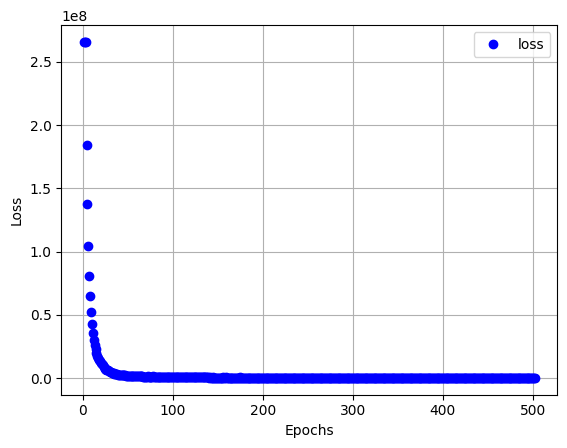

In [5]:
# 绘制损失变化情况
epochs = np.arange(len(trn_loss)) + 1
plt.plot(epochs, trn_loss, 'bo', label='loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


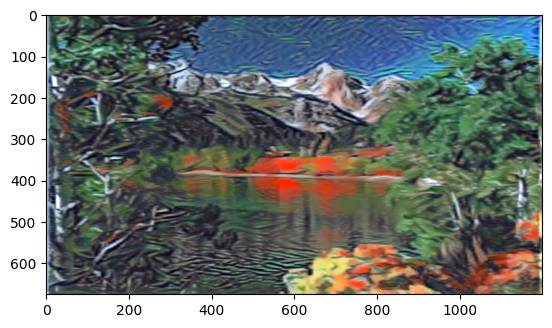

In [6]:
# 绘制 神经风格迁移 结果图像
with torch.no_grad():
    out_img = postprocess(opt_img[0]).permute(1,2,0)
plt.imshow(out_img.detach().cpu())
plt.show()
